# survey experiments: v1 (prescription medications)

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

Prescription medications are tricky for the model because of their attribute level values.

Delivery wait time:
- 30 minutes
- 2 hrs (120 minutes)
- 6 hrs (360 minutes)
- 1 day (1440 minutes)



In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [2]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,freq_takeout_food,v_type,g_cost,d_cost,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,1,liquor store,0,0,20,15,0,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,1,liquor store,3,0,20,20,0,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,1,take-out food,0,3,45,20,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,1,prescription medications,10,0,30,360,0,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,1,liquor store,5,0,45,45,0,0,-5,0


### Add values to the choice question parameters



In [3]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)
for levels in [VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS]:
    print(levels)

[('take-out food', 'take-out food'), ('prescription medications', 'prescription medications'), ('liquor store', 'items from a liquor store'), ('last-minute groceries', 'last-minute groceries')]
[[(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (5, '$5'), (10, '$10')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]]
[[(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(30, '30 minutes'), (120, '2 hrs'), (360, '6 hrs'), (1440, '1 day')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]]
[(0, 'NO privacy'), (1, 'YES privacy')]


## Different for v1: Add in extra columns evaluating trade-offs

Here we consider the difference in levels of time, vs minute values

In [4]:
choices_df['dt_less_gt'] = choices_df['dt'] - choices_df['gt']
choices_df.head(3)

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,v_type,g_cost,d_cost,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost,ID,dt_less_gt
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,liquor store,0,0,20,15,0,-5,0,0,-1
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,liquor store,3,0,20,20,0,0,-3,0,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,take-out food,0,3,45,20,0,-25,3,0,-2


In [5]:
color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor, use_levels=False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        time_diff_col = 'dt_less_gt' if use_levels else 'd_time - g_time'
        df_p_agg = df_p[df_p['choice']==0].groupby(
            [time_diff_col,'d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            [time_diff_col,'d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg[time_diff_col],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg[time_diff_col],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        x_label = 'time level difference' if use_levels else 'drone wait time - ground vehicle wait time (mins)'
        ax.set_xlabel(x_label)
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

## Focus on v1 : prescription medications

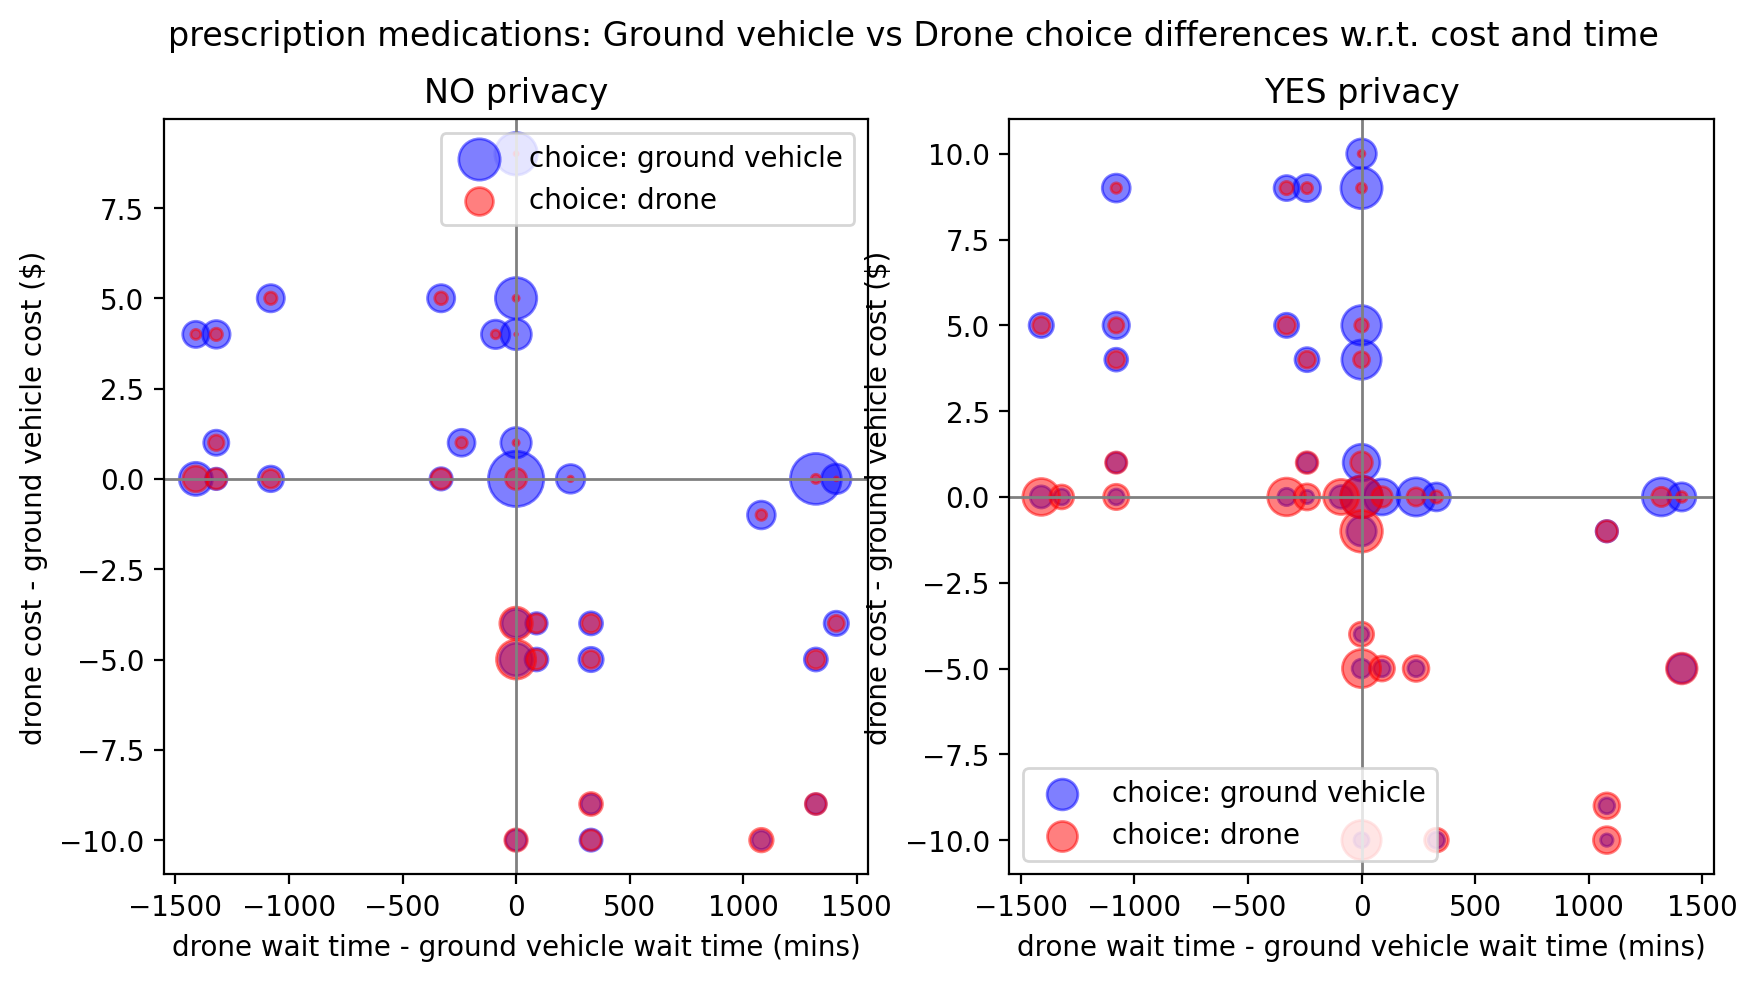

by difference in levels of time increments vs actual time


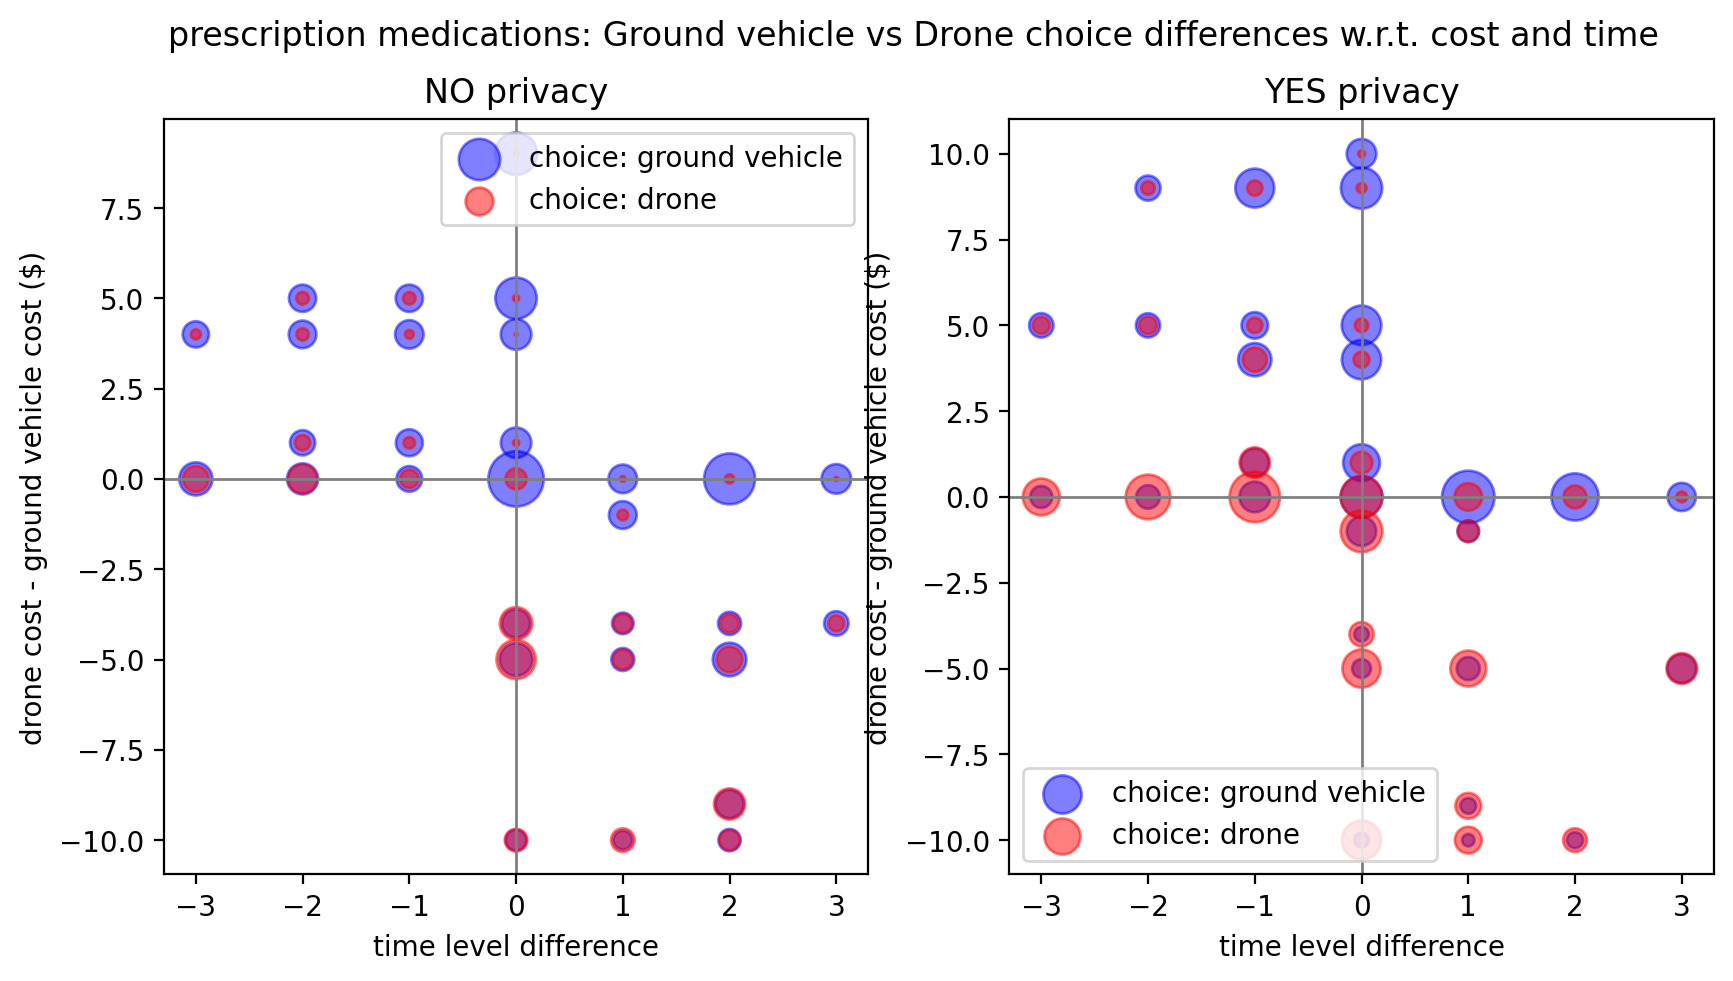

In [6]:
v=1
vdf = choices_df[choices_df['v']==v]
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0])
plt.show()
print('by difference in levels of time increments vs actual time')
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0], use_levels=True)

## Dummy models



Note that this simple logistic regression model does NOT work when the time variables are in real minute values. But DOES work when they are in values by level.

With this information time levels in the biogeme models.

In [7]:
from pymer4.models import Lmer

In [8]:
usecols = [
    'choice',
    'dt_less_gt',
    'd_cost - g_cost',
    'd_privacy',
    'ResponseId'
]
v_choices_df = vdf[usecols]
formula = 'choice ~ dt_less_gt + d_cost_minus_g_cost + d_privacy + (1|ResponseId)'
m = Lmer(formula, data=v_choices_df.rename(columns={
        'd_cost - g_cost':'d_cost_minus_g_cost',
    }), family='binomial')
print(m.fit())

Formula: choice~dt_less_gt+d_cost_minus_g_cost+d_privacy+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 11481	 Groups: {'ResponseId': 3323.0}

Log-likelihood: -5643.257 	 AIC: 11296.513

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  2.473  1.573

No random effect correlations specified

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.998  -2.125   -1.871  0.065  0.136      0.119   
dt_less_gt             -0.714  -0.764   -0.663  0.026  0.490      0.466   
d_cost_minus_g_cost    -0.400  -0.421   -0.379  0.011  0.670      0.656   
d_privacy               1.827   1.692    1.962  0.069  6.216      5.429   

                     OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)               0.154  0.119        0.107         0.133 -30.891   
dt_less_gt                0.515  0.329        0.318         0.340 -27.731   
d_cost_minus_g_cost  

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


### Initial simple experiments

#### Generic vs alternative specific attributes.
We want to use alternative specific attributes, but start with generic.


#### Random coefficients
We want to model random effects/taste variation with a random parameter logit model. However, we start without this.


#### Iterative modeling process:

Start simplest, add complexity and use statistical tests to determine whether changes to the model add significant explanatory power.

Tests used:
- (baseline) verify parameters have expended signs
- (simplest) t-test: use t-test values and p-values to evaluate whether a parameter is statistically significant
- adjusted likelihood ratio index (rho bar squared) $\bar{\rho^2}$: evaluate whether adding a variable had a positive impact on this metric
- use likelihood ratio test

Modeling steps:

- generic model without free parameter
- add free paramter and test whether it adds statistically siginicant explanatory power
- test alternatve specific time parameter
- test alternative specific cost parameter
- -- not for now: test impact of random coefficients
    - this is not done in related work by Haan et al (2021); complicates estimation of VOT?
- test addition of socioeconomic variables and interactions with privacy parameter:
    - gender
    - age: dummy variable for older; dummy variable for younger
    - residential type: dummy variables:
        - private home, apartment
    - residential area: dummy:
        - urban, suburban, rural
- test addition of consumer behavior and interactions with privacy parameter:
    - dummy variables:
        - online shopping more than 1x/week
        - take-out food delivery more than 1x/week


#### Test with $\bar{\rho^2}$

Ben Akiva & Lerman (1985):

For the same estimation data set, the $\rho^2$ of a model always increases or at least stays the same whenever new variables are added to the model, a limitation it shares with regression statistic $R^2$. For this reason we also use the adjusted likelihood ratio index (rho bar squared):

$$
\bar{\rho^2} = 1 - \frac{L(\tilde{\beta}) - K }{L(0)}
$$
where K denotes the number of unknown parameters in the model.

#### Test with likelihood ratio test: generic vs alternative-specific attributes

Specify models with both generic and alternative-specific attributes.

Then use the likelihood ratio test (pages 28 and 164-167 in Ben Akiva & Lerman (1985)) to test which model specification should be used.

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e. for cost and time:

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$ & $\beta_{g\_time} = \beta_{d\_time}$

The test statistic for the null hypothesis is 

$-2(L_R - L_U)$

which is asymtotically distributed as $X^2$ with $df = K_U - K_R$ degrees of freedom, where $K_U$, $K_R$ are the number of estimated parameters in the unrestricted and restricted models.

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom.

In [9]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [10]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    # NOTE THE DIFFERENCE HERE -- values are by level, not minutes
    'gt',         # ground vehicle delivery wait time
    'dt',         # drone delivery wait time
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'age_young',
    'age_old',
    'residence_house',
    'residence_apartment',
    'urban',
    'suburban',
    'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
    
]

In [11]:
model_df = choices_df[choices_df['v']==v][model_choice_cols]
print('choices without excluding free alternatives: N=%s'%len(model_df))
model_df.head(7)

choices without excluding free alternatives: N=11481


,ID,choice,d_privacy,g_cost,d_cost,gt,dt,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food
3,0,1,0,10,0,0,2,1,1,0,0,1,1,0,0,0,1
5,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1
7,0,1,0,5,1,0,1,1,1,0,0,1,1,0,0,0,1
18,1,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0
19,1,0,1,1,5,2,1,0,1,0,1,0,0,1,0,0,0
20,1,0,0,0,5,2,2,0,1,0,1,0,0,1,0,0,0
23,2,0,0,1,1,1,3,0,0,0,1,0,0,1,0,0,0


In [12]:
def get_vendor_panel_database(v, name=None, free_col=True):
    """Returns new fresh database each time."""
    db_name = name if name else 'v%s'%v
    df = choices_df[choices_df['v']==v][model_choice_cols]
    if free_col:
        df['g_free'] = df['g_cost'].apply(lambda c: 1 if c==0 else 0)
        df['d_free'] = df['d_cost'].apply(lambda c: 1 if c==0 else 0)
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [13]:
database = get_vendor_panel_database(v)
database.data.head()

,ID,choice,d_privacy,g_cost,d_cost,gt,dt,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
0,0,1,0,10,0,0,2,1,1,0,0,1,1,0,0,0,1,0,1,1
1,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,0,1,1,0,1
2,0,1,0,5,1,0,1,1,1,0,0,1,1,0,0,0,1,0,0,1
3,1,1,1,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,2
4,1,0,1,1,5,2,1,0,1,0,1,0,0,1,0,0,0,0,0,2


In [14]:
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. Use all the
# Pandas functions to invesigate the database
database.data.describe()

,ID,choice,d_privacy,g_cost,d_cost,gt,dt,male,age_young,age_old,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food,g_free,d_free,_biogroups
count,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000
mean,1880.146851,0.378277,0.557704,4.088668,3.796708,1.536713,1.562669,0.482885,0.488111,0.152339,0.714398,0.257904,0.262869,0.552652,0.179253,0.186308,0.058009,0.182040,0.252417,1671.805853
std,1069.919982,0.484978,0.496681,3.804931,3.808133,1.116661,1.106252,0.499729,0.499880,0.359364,0.451720,0.437500,0.440211,0.497242,0.383580,0.389372,0.233770,0.385894,0.434418,956.338564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,979.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,858.000000
50%,1885.000000,0.000000,1.000000,5.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1668.000000
75%,2801.000000,1.000000,1.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2496.000000
max,3714.000000,1.000000,1.000000,10.000000,10.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3323.000000


In [15]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

def print_biogeme_results(results):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    print(results.getEstimatedParameters())
    print('\n---- Model statistics ----\n')
    print('sample size: N=%s' % results.data.sampleSize)
    print('observations: n=%s' % results.data.numberOfObservations)
    print('no. of parameters: K=%s' % results.data.nparam)
    print('log likelihood: LL=%s' % results.data.logLike)
    print('adjusted likelihood ratio index: rho-bar-squared:=%s' % results.data.rhoBarSquare)
    

### Simplest generic model

In [16]:
# without the random utility model we estimate models without using PanelLikelihoodTrajectory
# This is based on instruction from Professor Bierlaire (Biogeme author)
# see https://groups.google.com/g/biogeme/c/1CDNIpQoGPw

In [17]:
"""
Generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * gt
V_drone =  B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy
(drone used as reference for ASC's)
"""

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G = Beta('ASC_G', 0, None, None, 0)
ASC_D = Beta('ASC_D', 0, None, None, 1) # 1: this will not change and will make this the reference for ASC's
B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)
# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'v%s_generic_logit_1'%v
# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
generic_logit_results = biogeme.estimate()
print_biogeme_results(generic_logit_results)

Model: v1_generic_logit_1

---- Coefficients ----
               Value   Std err     t-test  p-value  Rob. Std err  Rob. t-test  \
ASC_G       1.388632  0.071001  19.557986      0.0      0.069028    20.116931   
B_COST     -0.293098  0.012425 -23.588510      0.0      0.013444   -21.801445   
B_DPRIVACY  1.258175  0.088932  14.147580      0.0      0.088807    14.167507   
B_TIME     -0.556358  0.033679 -16.519556      0.0      0.033821   -16.450074   

            Rob. p-value  
ASC_G                0.0  
B_COST               0.0  
B_DPRIVACY           0.0  
B_TIME               0.0  

---- Model statistics ----

sample size: N=3323
observations: n=11481
no. of parameters: K=4
log likelihood: LL=-1759.0707331172878
adjusted likelihood ratio index: rho-bar-squared:=0.2345550997879099


In [18]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)

betas = generic_logit_results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % vop)

VOT ($) for ground vehicle: 1.90
how to evaluate value of privacy?
value of privacy ($) for drone: -4.29


### Alternative specific variance

We have panel data and reason to assume that the preference for drone/ground delivery is highly variable among individuals and should capture that agent level effect. We do this by specifying an alternative specific variance model.

Here the parameters for time, cost, and the ASC's are randomly
distributed with a normal distribution.

For the ASCs:
The normalization is not arbitrary. Only the minimum variance alternative should be normalized to 0. Therefore, proper estimation first requires the unidentified model be estimated (with all 2 variances in this case). Then the model should be re-estimated with the smallest variance from the unidentified model normalized to 0.

We therefore do this in 2 stages below.

1. Estimate all variances
2. Fix minimum variance alternative to 0. Also use the parameter values from (1) as starting values for faster estimation.

For 1,2, see Biogeme's files for example: 12panel,13panel.

In [19]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

1. estimate all ASC variances to identify minimum variance alternative.

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # initially fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0)
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 100 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'Initial estimation of model with alternative specific variance. '
        'Rerun this model where the minimum variance ASC is fixed to 0.'
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_1'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

100 draws
start time: 12:37:52
[12:37:52] < Warning >   Cannot read file __v1_generic_logit_asc_variance_1.iter. Statement is ignored.
end time: 12:39:16
Model: v1_generic_logit_asc_variance_1

---- Coefficients ----
               Value   Std err     t-test   p-value  Rob. Std err  \
ASC_D_MEAN -2.033436  0.066321 -30.660418  0.000000      0.070043   
ASC_D_S     1.493888  0.175474   8.513421  0.000000      0.240370   
ASC_G_S     0.794197  0.319124   2.488679  0.012822      0.450000   
B_COST     -0.406476  0.010799 -37.638475  0.000000      0.012108   
B_DPRIVACY  1.856822  0.070145  26.471055  0.000000      0.075983   
B_TIME     -0.724855  0.026045 -27.830771  0.000000      0.027129   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -29.031349  0.000000e+00  
ASC_D_S        6.214952  5.134031e-10  
ASC_G_S        1.764883  7.758336e-02  
B_COST       -33.570574  0.000000e+00  
B_DPRIVACY    24.437366  0.000000e+00  
B_TIME       -26.719165  0.000000e+00  

---- Model statist

The variance for ground vehicle is not statistically significant.

For convenience, we use the same specification here as for v2:

We estimate the models with the ground vehicle ASC normalized to 0.

For completeness, we continue with step 2.

In [20]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = B_cost * g_cost + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

2. Fix minimum variance alternative to 0. 
Also use the parameter values from (1) as starting values for faster estimation.

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning()

draws = 500 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'Second estimation of model with alternative specific variance. '
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_2'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

500 draws
start time: 12:39:27
[12:39:27] < Warning >   Cannot read file __v1_generic_logit_asc_variance_2.iter. Statement is ignored.
end time: 12:47:17
Model: v1_generic_logit_asc_variance_2

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -2.037275  0.066669 -30.558219  0.000000e+00      0.069857   
ASC_D_S     0.898558  0.282733   3.178114  1.482363e-03      0.154672   
ASC_G_S     1.449063  0.181704   7.974867  1.554312e-15      0.105807   
B_COST     -0.407949  0.010860 -37.565865  0.000000e+00      0.012180   
B_DPRIVACY  1.864784  0.070468  26.462917  0.000000e+00      0.076283   
B_TIME     -0.726783  0.026159 -27.783693  0.000000e+00      0.027252   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -29.163498  0.000000e+00  
ASC_D_S        5.809427  6.268705e-09  
ASC_G_S       13.695354  0.000000e+00  
B_COST       -33.492226  0.000000e+00  
B_DPRIVACY    24.445473  0.000000e+00  
B_TIME       -26.668994  0.0000

In [21]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)

betas = results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST ($1)
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % vop)

VOT ($) for ground vehicle: 1.78
how to evaluate value of privacy?
value of privacy ($) for drone: -4.57


#### Results overview

The VOT barely changed (good).

The $\bar{\rho^2}$ is improved over the model without the alternative specific variance -- indicating the alternative specific variance model is an improvement.


### Adding a coefficient for free

In [23]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test free after alternative specific variance'
    )
)
biogeme.modelName = 'v%s_generic_asv_free'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(results)

200 draws
start time: 14:29:38
[14:29:38] < Warning >   Cannot read file __v1_generic_asv_free.iter. Statement is ignored.
end time: 14:34:30
Model: v1_generic_asv_free

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -2.027852  0.066562 -30.465839  0.000000e+00      0.069834   
ASC_D_S    -1.066998  0.279681  -3.815053  1.361535e-04      0.264801   
ASC_G_S     1.322177  0.229491   5.761355  8.344109e-09      0.220120   
B_COST     -0.391827  0.011377 -34.440407  0.000000e+00      0.012287   
B_DPRIVACY  1.836851  0.070607  26.015211  0.000000e+00      0.076484   
B_FREE      0.240393  0.063975   3.757594  1.715551e-04      0.064287   
B_TIME     -0.733651  0.026316 -27.878175  0.000000e+00      0.027527   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -29.038381  0.000000e+00  
ASC_D_S       -4.029432  5.591177e-05  
ASC_G_S        6.006610  1.894428e-09  
B_COST       -31.890283  0.000000e+00  
B_DPRIVACY    24.01607

In [24]:
results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-2.027852,0.066562,0.000000e+00
B_COST,-0.391827,0.011377,0.000000e+00
B_DPRIVACY,1.836851,0.070607,0.000000e+00
B_TIME,-0.733651,0.026316,0.000000e+00
ASC_G_S,1.322177,0.229491,8.344109e-09
ASC_D_S,-1.066998,0.279681,1.361535e-04
B_FREE,0.240393,0.063975,1.715551e-04


In [68]:
betas = results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)


print('how to evaluate value of privacy?')
vop = betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % vop)
# B_PRIVACY/B_COST

VOT ($) for ground vehicle: 1.87
how to evaluate value of privacy?
value of privacy ($) for drone: -4.67


#### Results

Overall, adding a coefficient to represent whether delivery is free seems to improve the model.

- free coefficient statistically significant
- slightly improved value for $\bar{\rho^2}$
- VOT barely changed even though free is statistically significant


### Modeling with alternative-specific attributes

We use above model with generic time and cost coefficients as the restricted model.

We then test a (unrestricted model) specification with alternative specific cost coefficient.

In [25]:
# get previous model results (restricted model) for comparison
restricted_results = results

#### Test alternative specific time coefficient

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_time} = \beta_{d\_time}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [26]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_g_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_d_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
time coefficient is alternative specific

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_G_TIME = Beta('B_G_TIME', 0, None, None, 0)
B_D_TIME = Beta('B_D_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1
# TODO: potentially scale cost and time values, similar to biogeme examples.
# From biogeme documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# Variables can be also be rescaled. For numerical reasons, it is good practice to scale 
# the data so that the values of the estimated parameters are around 1.

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_G_TIME*gt
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_D_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
# logger = msg.bioMessage()
# logger.setWarning() # .setGeneral() .setDetailed() << other options for messages
msg.bioMessage().setWarning()

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test alternative specific time coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_time'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(unrestricted_results)

200 draws
start time: 14:34:38
[14:34:38] < Warning >   Cannot read file __v1_as_time.iter. Statement is ignored.
end time: 14:38:45
Model: v1_as_time

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -2.018824  0.086311 -23.390070  0.000000e+00      0.090943   
ASC_D_S    -1.065861  0.279375  -3.815164  1.360926e-04      0.264076   
ASC_G_S     1.323137  0.228854   5.781578  7.400298e-09      0.219167   
B_COST     -0.391509  0.011538 -33.933449  0.000000e+00      0.012532   
B_DPRIVACY  1.837174  0.070639  26.008051  0.000000e+00      0.076335   
B_D_TIME   -0.736555  0.031703 -23.233184  0.000000e+00      0.032124   
B_FREE      0.242032  0.064742   3.738431  1.851721e-04      0.065751   
B_G_TIME   -0.730466  0.032672 -22.357796  0.000000e+00      0.034383   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -22.198755  0.000000e+00  
ASC_D_S       -4.036185  5.432741e-05  
ASC_G_S        6.037116  1.568931e-09  
B_COST 

Perform the likelihood ratio test

In [27]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_2,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=0.0271
X_2,0.05 = 3.84
cannot reject the null hypothesis


#### Test alternative specific cost coefficient


Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [28]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
cost coefficient is alternative specific

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of new variables

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_G_COST*g_cost + B_FREE*g_free + B_TIME*gt
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test alternative specific cost coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_cost'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(unrestricted_results)

200 draws
start time: 14:38:52
[14:38:52] < Warning >   Cannot read file __v1_as_cost.iter. Statement is ignored.
end time: 14:45:56
Model: v1_as_cost

---- Coefficients ----
               Value   Std err     t-test       p-value  Rob. Std err  \
ASC_D_MEAN -1.875009  0.073575 -25.484233  0.000000e+00      0.077012   
ASC_D_S     1.066211  0.283982   3.754495  1.736912e-04      0.271731   
ASC_G_S    -1.325845  0.232446  -5.703885  1.171070e-08      0.225366   
B_DPRIVACY  1.865341  0.071181  26.205462  0.000000e+00      0.076875   
B_D_COST   -0.417056  0.012877 -32.386846  0.000000e+00      0.013696   
B_FREE      0.241968  0.063900   3.786697  1.526629e-04      0.063832   
B_G_COST   -0.371451  0.012103 -30.690578  0.000000e+00      0.013005   
B_TIME     -0.732890  0.026436 -27.723507  0.000000e+00      0.027637   

            Rob. t-test  Rob. p-value  
ASC_D_MEAN   -24.346874  0.000000e+00  
ASC_D_S        3.923776  8.717177e-05  
ASC_G_S       -5.883067  4.027326e-09  
B_DPRIV

Perform the likelihood ratio test

In [29]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_1,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=21.0631
X_1,0.05 = 3.84
can reject the null hypothesis


#### Results

- LLR Test indicates time NOT alternative specific
- LLR Test *very much* indicates cost is alternative specific
- $\bar{\rho^2}$ is slightly improved with alternative specific cost

### Socioeconomic variables and interactions with privacy parameter

We add in the following parameters which we assume are generic across drone and ground vehicle delivery.

- gender: male/other (1/0)
- age: age_young, age_old (0/1)
- residential type: residence_house, residence_apartment (0/1)
- residential area: urban, suburban, rural (0/1)

In [32]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * d_time + B_dprivacy * d_privacy
    + B_male * male + B_gender_privacy * gender * d_privacy
    + B_age_young * age_young + B_age_old * age_old
    + B_residence_house * residence_house 
    + B_residence_apartment * residence_apartment
    + B_urban * urban 
    + B_suburban * suburban 
    + B_rural * rural
    + [demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
# B_D_COST = Beta('B_D_COST', 0, None, None, 0)
# B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_RESIDENCE_HOUSE = Beta('B_RESIDENCE_HOUSE', 0, None, None, 0)
B_RESIDENCE_APARTMENT = Beta('B_RESIDENCE_APARTMENT', 0, None, None, 0)
B_RESIDENCE_HOUSE_PRIVACY = Beta('B_RESIDENCE_HOUSE_PRIVACY', 0, None, None, 0)
B_RESIDENCE_APARTMENT_PRIVACY = Beta('B_RESIDENCE_APARTMENT_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
B_RURAL = Beta('B_RURAL', 0, None, None, 0)
B_URBAN_PRIVACY = Beta('B_URBAN_PRIVACY', 0, None, None, 0)
B_SUBURBAN_PRIVACY = Beta('B_SUBURBAN_PRIVACY', 0, None, None, 0)
B_RURAL_PRIVACY = Beta('B_RURAL_PRIVACY', 0, None, None, 0)

# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*gt

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*dt \
    + B_DPRIVACY*d_privacy \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_RESIDENCE_APARTMENT*residence_apartment + B_RESIDENCE_APARTMENT_PRIVACY*residence_apartment*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy \
    + B_RURAL*rural + B_RURAL_PRIVACY*rural*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}

# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test with socioeconomic variables'
    )
)
biogeme.modelName = 'v%s_demographics'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demo_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(demo_results)

200 draws
start time: 15:15:42
[15:15:42] < Warning >   Cannot read file __v1_demographics.iter. Statement is ignored.
end time: 16:32:52
Model: v1_demographics

---- Coefficients ----
                                  Value   Std err     t-test       p-value  \
ASC_D_MEAN                    -3.071366  0.728367  -4.216784  2.478109e-05   
ASC_D_S                        1.438262  0.287196   5.007952  5.501212e-07   
ASC_G_S                        0.836779  0.494297   1.692869  9.048046e-02   
B_AGE_OLD                     -0.271534  0.173372  -1.566200  1.173019e-01   
B_AGE_OLD_PRIVACY             -0.253464  0.189916  -1.334611  1.820037e-01   
B_AGE_YOUNG                   -0.045292  0.119631  -0.378600  7.049851e-01   
B_AGE_YOUNG_PRIVACY            0.402466  0.134543   2.991348  2.777486e-03   
B_COST                        -0.395387  0.011487 -34.421160  0.000000e+00   
B_DPRIVACY                     2.939154  0.909718   3.230840  1.234270e-03   
B_FREE                         0.24

In [33]:
demo_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
B_TIME,-0.741936,0.026502,0.000000e+00
B_COST,-0.395387,0.011487,0.000000e+00
B_MALE,0.809249,0.110687,2.648992e-13
ASC_D_S,1.438262,0.287196,5.501212e-07
ASC_D_MEAN,-3.071366,0.728367,2.478109e-05
B_FREE,0.244725,0.064015,1.318708e-04
B_DPRIVACY,2.939154,0.909718,1.234270e-03
B_AGE_YOUNG_PRIVACY,0.402466,0.134543,2.777486e-03
B_MALE_PRIVACY,-0.325338,0.122082,7.700657e-03
B_SUBURBAN_PRIVACY,-1.823934,0.841797,3.025661e-02


#### Results overview

residence:
- people who answered i don't know to what area they live in value privacy least?

age:
- age has no significance on likelihood to choose drone
- *young ppl value privacy more*
- TODO? could further pick apart age levels

gender
- males prefer drone more than others
- males value privacy less than others


### Consumer behavior attributes and interactions with privacy parameter

We add in the following attributes which we assume are generic across drone and ground vehicle delivery.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week

In [35]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
"""

np.random.seed(seed=12)

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', -1, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)


# To be consistent with Biogeme example -- is any availability indicator ever needed?
G_AV = 1
D_AV = 1

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_FREE*g_free + B_TIME*gt

VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*dt \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy \
    + B_FREQ_TAKEOUT_FOOD*freq_takeout_food \
    + B_FREQ_TAKEOUT_FOOD_PRIVACY*freq_takeout_food*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: G_AV, 1: D_AV}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 200 # use 100000 << TODO
# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    userNotes=(
        'test with consumer behavior variables'
    )
)
biogeme.modelName = 'v%s_freq_consumer'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
print_biogeme_results(cons_results)

200 draws
start time: 16:40:37
[16:40:37] < Warning >   Cannot read file __v1_freq_consumer.iter. Statement is ignored.
end time: 16:52:30
Model: v1_freq_consumer

---- Coefficients ----
                                Value   Std err     t-test   p-value  \
ASC_D_MEAN                  -2.095166  0.072843 -28.762605  0.000000   
ASC_D_S                      1.359896  0.290570   4.680093  0.000003   
ASC_G_S                      1.000319  0.395257   2.530805  0.011380   
B_COST                      -0.391657  0.011382 -34.409964  0.000000   
B_DPRIVACY                   1.853498  0.076910  24.099564  0.000000   
B_FREE                       0.245597  0.063929   3.841737  0.000122   
B_FREQ_ECOMMERCE             0.339908  0.139575   2.435300  0.014879   
B_FREQ_ECOMMERCE_PRIVACY    -0.274052  0.158026  -1.734219  0.082879   
B_FREQ_TAKEOUT_FOOD          0.077629  0.223604   0.347172  0.728462   
B_FREQ_TAKEOUT_FOOD_PRIVACY  0.415119  0.260581   1.593049  0.111149   
B_TIME               

In [37]:
cons_results.getEstimatedParameters().sort_values('p-value')[['Value', 'Std err', 'p-value']]

,Value,Std err,p-value
ASC_D_MEAN,-2.095166,0.072843,0.000000
B_COST,-0.391657,0.011382,0.000000
B_DPRIVACY,1.853498,0.076910,0.000000
B_TIME,-0.733203,0.026311,0.000000
ASC_D_S,1.359896,0.290570,0.000003
B_FREE,0.245597,0.063929,0.000122
ASC_G_S,1.000319,0.395257,0.011380
B_FREQ_ECOMMERCE,0.339908,0.139575,0.014879
B_FREQ_ECOMMERCE_PRIVACY,-0.274052,0.158026,0.082879
B_FREQ_TAKEOUT_FOOD_PRIVACY,0.415119,0.260581,0.111149


#### Results overview

- freq ecommerce only statistically significant coefficient.
- ppl who most frequently order ecommerce more likely to prefer drone